In [1]:
import os
import os.path as osp
import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
from nltk.corpus import stopwords
english_stopwords = stopwords.words("english")
import numpy as np
import re
import seaborn as sns
sns.set_theme(style="whitegrid")
import matplotlib.pyplot as plt
import pandas as pd
import string

import pickle
import random
import collections
from nltk.tokenize import sent_tokenize
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

In [2]:
def getFiles(path):
    all_files = os.listdir(path)
    text_files = [f for f in all_files if f[-3:]=='txt']
    ann_files = [f for f in all_files if f[-3:]=='ann']
    print("Numer of ann files: ", len(ann_files))
    print("Numer of text files: ", len(text_files))
    return text_files, ann_files


def labelIOBReactions(path, ann_files, text_files):
    reactions_per_document = []
    labels = {}
    ann_files.sort()
    text_files.sort()
    # 0: O (Outside) ; 1: I (Inside) ; 2: B (Beginning)
    for af, tf in zip(ann_files, text_files):
        
        with open(osp.join(path, tf), 'r',encoding="utf-8" ) as fp:
            with open(osp.join(path, af), 'r', encoding="utf-8" ) as ap:
                data = fp.read().rstrip()
                
                paras = data.count('\n')+1
              
                para_labels = np.zeros(paras)

                rpd = 0

                lines = ap.readlines()
                for line in lines:

                    ts = line.split()
                    if(ts[1] == "REACTION_SPAN"):
                        rpd +=1
                        st = data[:int(ts[2])].count('\n')
                        cnts = data[int(ts[2]):int(ts[3])].count('\n')+1
                        para_labels[st]=2; #beginning of a reaction
                        for i in range(st+1, st+cnts):
                            para_labels[i]=1; #inside a reaction
                            
                labels[tf[:-4]] = para_labels
                reactions_per_document.append(rpd)
    
    return labels, reactions_per_document

In [7]:
cv_path = "C:\\Users\\meais\\Documents\\CMU\\Independent Study\\ReactionExtraction\\data\\dev\\"
train_path = "C:\\Users\\meais\\Documents\\CMU\\Independent Study\\ReactionExtraction\\data\\train\\"

In [8]:
train_text_files, train_ann_files = getFiles(train_path)
dev_text_files, dev_ann_files = getFiles(cv_path)

Numer of ann files:  120
Numer of text files:  120
Numer of ann files:  30
Numer of text files:  30


In [73]:
dev_labels, dev_reactions_per_document = labelIOBReactions(cv_path, dev_ann_files, dev_text_files)
with open('dev_labels.pkl', 'wb') as f:
    pickle.dump(dev_labels, f)
print("Total dev reactions: ", sum(dev_reactions_per_document))

Total dev reactions:  1244


In [74]:
train_labels, train_reactions_per_document = labelIOBReactions(train_path, train_ann_files, train_text_files)
with open('train_labels.pkl', 'wb') as f:
    pickle.dump(train_labels, f)
print("Total train reactions: ", sum(train_reactions_per_document))

Total train reactions:  6378


In [75]:
def create_dataset(files, labels_dict, output_file, test_file=False):

  if(test_file):
      train_data = {'para':[], 'label':[], 'document':[]}
  else:
      train_data = {'para':[], 'label':[]}

  for f in files:
    with open(f, encoding="utf-8" ) as fp:
        
      lines = fp.readlines()
      train_data['para'].extend(lines)

      labels = labels_dict[f.split('\\')[-1][:-4]] #".txt"
      train_data['label'].extend(labels)
        
      if(test_file):
          train_data['document'].extend([f.split('\\')[-1] for i in range(len(lines))])
      

  nl = []
  for l in train_data['label']:
    if(l==1):
      nl.append("1")
    elif(l==2):
      nl.append("2")
    elif(l==0):
      nl.append("0")
    else:
      print("Label Error")
    
    
  train_data['label'] = nl

  df = pd.DataFrame(train_data)
  print(df.head())
  df.to_csv(output_file, index = False)


In [76]:
test_files = [osp.join(cv_path, f)  for f in os.listdir(cv_path) if f[-3:]=='txt']
print(len(test_files))
print(test_files[:5])

30
['C:\\Users\\meais\\Documents\\CMU\\Independent Study\\ReactionExtraction\\data\\dev\\EP3284738A1.txt', 'C:\\Users\\meais\\Documents\\CMU\\Independent Study\\ReactionExtraction\\data\\dev\\EP3305797A1.txt', 'C:\\Users\\meais\\Documents\\CMU\\Independent Study\\ReactionExtraction\\data\\dev\\EP3312182A1.txt', 'C:\\Users\\meais\\Documents\\CMU\\Independent Study\\ReactionExtraction\\data\\dev\\EP3323817A1.txt', 'C:\\Users\\meais\\Documents\\CMU\\Independent Study\\ReactionExtraction\\data\\dev\\EP3330263A1.txt']


In [82]:
train_files = [osp.join(train_path, f) for f in os.listdir(train_path) if f[-3:]=='txt']
print(len(train_files))
random.shuffle(train_files)

val_files = train_files[:20]
train_files = train_files[20:]

print(len(train_files))
print(len(val_files))

120
100
20


In [83]:
# create_dataset(dev_files, pickle.load(open(dev_label_path, "rb")), "dev_data.csv") # test set
create_dataset(test_files, pickle.load(open("dev_labels.pkl", "rb")), "test_data_iob.csv", test_file=True) # test set
create_dataset(train_files, pickle.load(open("train_labels.pkl", "rb")), "train_data_iob.csv", test_file=True) #train_set
create_dataset(val_files, pickle.load(open("train_labels.pkl", "rb")), "val_data_iob.csv", test_file=True) # validation set

                                                para label         document
0                           FIELD OF THE INVENTION\n     0  EP3284738A1.txt
1  The present invention relates to the field of ...     0  EP3284738A1.txt
2                      BACKGROUND OF THE INVENTION\n     0  EP3284738A1.txt
3  Glutamate which is the most important excitato...     0  EP3284738A1.txt
4  Glutamate receptors (GluR) are mainly divided ...     0  EP3284738A1.txt
                                                para label          document
0  The present invention relates to phosphorescen...     0  US10868254B2.txt
1  In OLEDs, the electroluminescence (EL) charact...     0  US10868254B2.txt
2  In other words, in case of organic light-emitt...     0  US10868254B2.txt
3                                     1. Substrate\n     0  US10868254B2.txt
4  2. Base electrode, hole-injecting (positive po...     0  US10868254B2.txt
                                                para label  \
0          CROSS-REF

In [84]:
df = pd.read_csv("test_data_iob.csv")
print(len(df))
collections.Counter(df['label'])

12871


Counter({0: 9881, 2: 1236, 1: 1754})

In [85]:
df = pd.read_csv("train_data_iob.csv")
print(len(df))
collections.Counter(df['label'])

46018


Counter({0: 34567, 2: 5192, 1: 6259})

In [86]:
df = pd.read_csv("val_data_iob.csv")
print(len(df))
collections.Counter(df['label'])

7545


Counter({0: 5486, 2: 911, 1: 1148})

## Create DS for Eval

In [13]:
gtest_path = "/projects/NO-BACKUP/chem_nlp/data/dow_polyurethane/test"
text_files, ann_files = getFiles(gtest_path)

Numer of ann files:  179
Numer of text files:  179


In [27]:
def create_dataset_extraction(path, text_files):
    para_cnts = []
    df = {'para':[], 'label':[], 'document':[]}
    text_files.sort()
    for tf in text_files:
        with open(osp.join(path, tf), 'r',encoding="utf-8" ) as fp:
            data = fp.read().rstrip()
            para_fin = data.split('\n')
            paras = []
            for p in para_fin:
                alpn = len([ele for ele in p if ele.isalnum()])
                hashes = len([ele for ele in p if ele=='='])
                if(p.strip()!='' and not (hashes >= 12 and alpn <= 4)):
                    paras.append(p.strip()+'\n')
            
            # paras = [p+'\n' for p in para_fin if p.strip()!='']
            para_cnts.append(len(paras))
            df['para'].extend(paras)
            df['label'].extend([0 for i in range(len(paras))])
            df['document'].extend([tf for i in range(len(paras))])

    return pd.DataFrame(df), para_cnts

In [29]:
df, para_cnts = create_dataset_extraction(gtest_path, text_files)
print(len(df))
df.head(20)


8327


,para,label,document
0,================ TITLE ================\n,0,US10029427.txt
1,Process for the production of storage-stable polyurethane prepregs and mouldings produced therefrom from dissolved polyurethane composition\n,0,US10029427.txt
2,=============== ABSTRACT ==============\n,0,US10029427.txt
3,"The invention relates to a method for producing storage-stable polyurethane prepregs and molding bodies produced therefrom (composite components), which can be obtained by a method using a polyurethane composition in solution and by impregnation of fiber-reinforced materials such as of woven fabrics and laid scrim using reactive polyurethane compositions.\n",0,US10029427.txt
4,EXAMPLES\n,0,US10029427.txt
5,"Glass fibre nonwovens/fabrics used: The following glass fibre nonwovens/fabrics were used in the examples, glass filament fabric 296 g/m 2 —Atlas, Finish FK 144 (Interglas 92626) Reactive Polyurethane Composition Reactive polyurethane compositions with the following formulae were used for the production of the prepregs and the composites. The starting materials in the table are intimately mixed in a premixer and then dissolved in the stated solvent. To produce the prepreg, the glass fibre fabric is saturated with the solution of the matrix materials. The prepregs are dried to constant weight in an oven at temperatures of from 50 to 70° C., optionally with application of vacuum. The matrix volume content is determined as 34.2% in Example 1 (10 tests) and 33.9% in Example 2 (6 tests). The fibre volume contents are corresponding 65.8% (Example 1) and 66.1% (Example 2). DSC Measurements The DSC tests (glass transition temperature determinations and enthalpy of reaction measurements) are performed with a Mettler Toledo DSC 821e as per DIN 53765. The DSC studies of the prepregs from Examples 1 and 2 gives the following results: The glass transition temperatures measured during the second heating procedure are the glass transition temperatures of the fully reacted/crosslinked matrix material. Storage Stability of the Prepregs The DSC studies of the prepregs from Examples 1 and 2 give the following results measured after 18 and, respectively, 40 days, seen in FIGS. 1 and 2 . The reaction enthalpies measured do not decrease significantly during the course of storage, and this provides evidence of the reactivity of the matrix material. Composite Component Production The composite components are produced on a composite press by a compression technique known to those skilled in the art. The homogeneous prepregs produced by direct impregnation were compressed into composite materials on a benchtop press. This benchtop press is the Polystat 200 T from the firm Schwabenthan, with which the prepregs are compressed to the corresponding composite sheets at temperatures between 120 and 200° C. The pressure is varied between normal pressure and 450 bar. Dynamic compression, i.e. alternating applications of pressure, can prove advantageous for the crosslinking of the fibres depending on the component size, component thickness and polyurethane composition and hence the viscosity setting at the processing temperature. In one example, the temperature of the press is adjusted to 150° C. and, in the course of compression, increased to 180° C., the pressure is increased to 5 bar after a short melting phase of 3 minutes and held until the removal of the composite component from the press after up to 30 minutes. The hard, rigid, chemicals resistant and impact resistant composite components (sheet products) are tested for the degree of curing (determination by DSC). With the polyurethane composition used, the crosslinking is complete after ca. 20 minutes, and then an enthalpy of reaction for the crosslinking reaction is also no longer detectable.\n",0,US10029427.txt
6,=============== CLAIMS ==============\n,0,US10029427.txt
7,"1. A process of producing a prepreg, the process comprising, in the following order: directly impregnating a fibrous support wi

In [30]:
df.to_csv("gtest_iob_modified.csv", index = False)

Total para counts:  8327
819


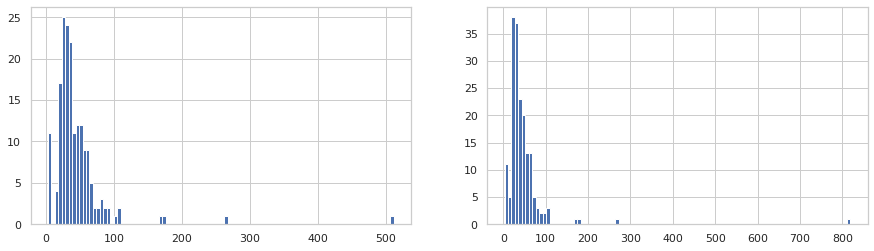

In [31]:
def visualize(values, max_val = 512, bins = 100):#512 is bert token limit
    print(max(values))
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,4))
    _,_,_ = ax1.hist([min(w, 512) for w in values],bins = bins)
    _,_,_ = ax2.hist([w for w in values],bins = bins) 

print("Total para counts: ", sum(para_cnts))
visualize(para_cnts)

In [1]:
#######################################################################################################################

## Sentence based models

In [7]:
text = "2-ethynylpyridine was replaced by 2-methyl-4-ethynyloxazole, while the remaining raw materials, reagents and the preparation method were the same as those in Example 1 to give the product ZD090, yield 80%. 1H NMR (400 MHz, CDCl3) δ7.393 (1H, dd), 8.492 (1H, dd), 7.892 (1H, dd), 7.741 (1H, ddd), 7.741 (1H, ddd), 7.017 (1H, ddd), 7.018 (1H, ddd), 7.383 (s, 1H), 2.547 (s, 3H). LRMS (EI) m/z 339(M+)."
l = sent_tokenize(text)
for p in l:
    print(p)

2-ethynylpyridine was replaced by 2-methyl-4-ethynyloxazole, while the remaining raw materials, reagents and the preparation method were the same as those in Example 1 to give the product ZD090, yield 80%.
1H NMR (400 MHz, CDCl3) δ7.393 (1H, dd), 8.492 (1H, dd), 7.892 (1H, dd), 7.741 (1H, ddd), 7.741 (1H, ddd), 7.017 (1H, ddd), 7.018 (1H, ddd), 7.383 (s, 1H), 2.547 (s, 3H).
LRMS (EI) m/z 339(M+).


In [3]:
def getFiles(path):
    all_files = os.listdir(path)
    text_files = [f for f in all_files if f[-3:]=='txt']
    ann_files = [f for f in all_files if f[-3:]=='ann']
    print("Numer of ann files: ", len(ann_files))
    print("Numer of text files: ", len(text_files))
    return text_files, ann_files


def labelIOBReactions(path, ann_files, text_files):
    reactions_per_document = []
    labels = {}
    ann_files.sort()
    text_files.sort()
    # 0: O (Outside) ; 1: I (Inside) ; 2: B (Beginning)
    for af, tf in zip(ann_files, text_files):
        
        with open(osp.join(path, tf), 'r',encoding="utf-8" ) as fp:
            with open(osp.join(path, af), 'r', encoding="utf-8" ) as ap:
                data = fp.read().rstrip()
                
                paras = data.count('\n')+1
              
                para_labels = np.zeros(paras)

                rpd = 0

                lines = ap.readlines()
                for line in lines:

                    ts = line.split()
                    if(ts[1] == "REACTION_SPAN"):
                        rpd +=1
                        st = data[:int(ts[2])].count('\n')
                        cnts = data[int(ts[2]):int(ts[3])].count('\n')+1
                        para_labels[st]=2; #beginning of a reaction
                        for i in range(st+1, st+cnts):
                            para_labels[i]=1; #inside a reaction
                            
                labels[tf[:-4]] = para_labels
                reactions_per_document.append(rpd)
    
    return labels, reactions_per_document

In [9]:
with open("C:\\Users\\meais\\Documents\\CMU\\Independent Study\\ReactionExtraction\\data\\dev\\EP3284738A1.txt", 'r',encoding="utf-8" ) as fp:
    data = fp.read().rstrip()
    print(data[55881: 56165])

2-fluoro-5-iodobenzoic acid was replaced by 2-chloro-5-iodobenzoic acid, and 4-fluoroaniline was replaced by 7-oxa-2-azaspiro [3.5] nonane, while the remaining raw materials, reagents and the preparation method were the same as those in Example 1 to give the product ZD002, yield 80%.
